# Summary

## T5

# Code

In [1]:
#@title Installs

!pip install pydot --quiet
!pip install -q transformers==4.37.2
!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 37.9 MB/s eta 0:00:00


In [2]:
#@title Imports

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler


## Load Data

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

# Data Path
train_data_path = '/content/gdrive/My Drive/W266 Final Project/datasets/train_data_binary.csv'
test_data_path = '/content/gdrive/My Drive/W266 Final Project/datasets/test_data_binary.csv'

# Load Raw Data
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

Mounted at /content/gdrive


## Data Overview

In [5]:
train_data.head()

,Comment,Labels
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
train_data.shape

(159571, 2)

array([[<Axes: title={'center': 'Labels'}>]], dtype=object)

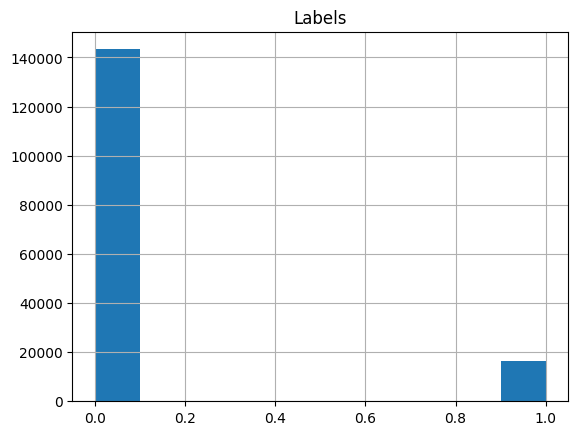

In [7]:
train_data.hist()

In [8]:
train_data['Labels'].value_counts()

Labels
0    143346
1     16225
Name: count, dtype: int64

In [9]:
#random undersampling with the same ratio
#check number of values per class
print("Before random undersampling", train_data['Labels'].value_counts())
# Splitting the data into train and test sets, but in this case, we'll only use the train set
train_subset, _ = train_test_split(train_data, test_size=0.6, random_state=42)

# If you want to reset the index of the subset
train_subset.reset_index(drop=True, inplace=True)
train_under = train_subset
print("After random undersampling", train_under['Labels'].value_counts())

Before random undersampling Labels
0    143346
1     16225
Name: count, dtype: int64
After random undersampling Labels
0    57280
1     6548
Name: count, dtype: int64


In [10]:
test_data.head()

,Comment,Labels
0,Thank you for understanding. I think very high...,0
1,:Dear god this site is horrible.,0
2,"""::: Somebody will invariably try to add Relig...",0
3,""" \n\n It says it right there that it IS a typ...",0
4,""" \n\n == Before adding a new product to the l...",0


In [11]:
test_data.shape

(63978, 2)

array([[<Axes: title={'center': 'Labels'}>]], dtype=object)

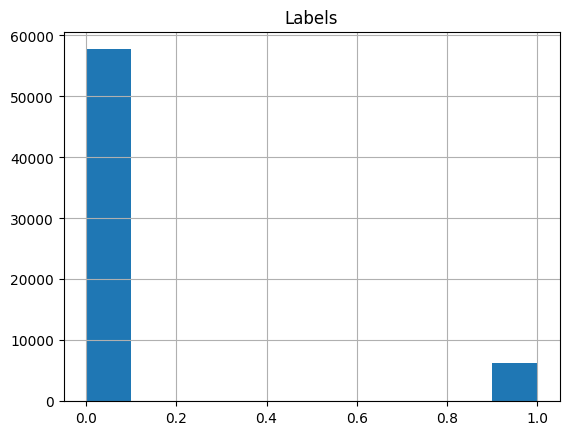

In [12]:
test_data.hist()

In [13]:
test_data['Labels'].value_counts()

Labels
0    57735
1     6243
Name: count, dtype: int64

In [14]:
#random undersampling with the same ratio
#check number of values per class
print("Before random undersampling", test_data['Labels'].value_counts())
# Splitting the data into train and test sets, but in this case, we'll only use the train set
test_subset, _ = train_test_split(test_data, test_size=0.6, random_state=42)

# If you want to reset the index of the subset
test_subset.reset_index(drop=True, inplace=True)
test_under = test_subset
print("After random undersampling", test_under['Labels'].value_counts())

Before random undersampling Labels
0    57735
1     6243
Name: count, dtype: int64
After random undersampling Labels
0    23130
1     2461
Name: count, dtype: int64


## Create train_texts, train_labels, valid_texts, valid_labels, test_texts, and test_labels

In [15]:
# Splitting the data into train and validation sets
train_data, val_data = train_test_split(train_under, test_size=0.2, random_state=42)

train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

In [16]:
train_texts = train_data['Comment']
train_texts

0        Christianity is only mentioned three times in ...
1        My Thoughts \n\nYou're a fucking piece of shit...
2        "\nIf you want to customize your userpage, you...
3                          Exactly how are my edits so bad
4        "\n If you'd actually take the time to look ar...
                               ...                        
51057    "\n\nThats not very nice for the people of San...
51058    November 2007 (UTC)\n\nI've been thinking of t...
51059    Track map? \n\nCan a track map be made by jdjo...
51060     "\nOK, but are they ""most"" ? Rajyaमहाराष्ट्र "
51061    William Cooley GA Nomination \n\nHi Horologium...
Name: Comment, Length: 51062, dtype: object

In [17]:
train_labels = train_data['Labels']
train_labels

0        0
1        1
2        0
3        0
4        0
        ..
51057    0
51058    0
51059    0
51060    0
51061    0
Name: Labels, Length: 51062, dtype: int64

In [18]:
valid_texts = val_data['Comment']
valid_texts

0        "\n\nFlyer is right, reliable sources are bein...
1        "\n\n Mistake in Map \n\nHello All,\n\nThe map...
2        "\nHi Rjensen. Thanks for getting back to me. ...
3        I have made no changes to the template, only a...
4        Further update: I've now discovered that the C...
                               ...                        
12761    "\n\nAward ceremony dates\nFound a source for ...
12762    Bio means life or living!! \n\nCell isn't mech...
12763    CJ DUB Continues To Insult Wiki Editors & User...
12764    "\nIf only you had followed your own advice a ...
12765    I think we should see what the RFC determines ...
Name: Comment, Length: 12766, dtype: object

In [19]:
valid_labels = val_data['Labels']
valid_labels

0        0
1        0
2        0
3        0
4        0
        ..
12761    0
12762    0
12763    0
12764    0
12765    0
Name: Labels, Length: 12766, dtype: int64

In [20]:
test_texts = test_under['Comment']
test_texts

0        Clayton High School \n Hello, I recently remov...
1        " \n\n  Please do not vandalize pages, as you ...
2                                  ::Learn to spell, yank.
3        " \n : As a member of the community, I have re...
4        == Eschew Obfuscation == \n\n If you're intere...
                               ...                        
25586    :Are you proposing something here or opining o...
25587    :I don't think there is sufficient reason to e...
25588    " \n\n == The harm of articles == \n\n Accordi...
25589    " \n\n == Local names 2nd time == \n\n  \n\n Y...
25590                fuckin super gay ass bitch headAlamos
Name: Comment, Length: 25591, dtype: object

In [21]:
test_labels = test_under['Labels']
test_labels

0        0
1        0
2        0
3        0
4        0
        ..
25586    0
25587    0
25588    0
25589    0
25590    1
Name: Labels, Length: 25591, dtype: int64

## T5

In [22]:
checkpoint = 't5-small'
# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained(checkpoint)
# Load the T5 model
model = TFT5ForConditionalGeneration.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [23]:
# ... (the rest of your code for loading model and tokenizer)
def convert_labels_to_text(labels):
    return ["not toxic" if label == 0 else "toxic" for label in labels]

def preprocess_texts(texts, labels, max_length=128):
    input_ids = []
    attention_masks = []
    label_ids = []
    for text, label in zip(texts, labels):
        # encode the text into tensor of input ids and attention masks
        input_encoding = tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='tf'
        )
        input_ids.append(input_encoding['input_ids'])
        attention_masks.append(input_encoding['attention_mask'])

        # For T5, labels should also be encoded with the same tokenizer, and they should be shifted to the right.
        # Assuming `labels` is a list of strings that need to be encoded as well.
        label_encoding = tokenizer(
            label,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='tf'
        )
        # Shift the label ids to the right
        label_ids.append(tf.concat([tf.zeros((1, 1), dtype=tf.int32), label_encoding['input_ids'][:, :-1]], axis=-1))

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    label_ids = tf.concat(label_ids, axis=0)

    return input_ids, attention_masks, label_ids

# Assuming you have functions to convert your raw text labels to strings that can be processed by the tokenizer
train_label_texts = convert_labels_to_text(train_labels)
valid_label_texts = convert_labels_to_text(valid_labels)
test_label_texts = convert_labels_to_text(test_labels)

# Apply the function to your data
train_input_ids, train_attention_masks, train_labels_encoded = preprocess_texts(train_texts, train_label_texts)
valid_input_ids, valid_attention_masks, valid_labels_encoded = preprocess_texts(valid_texts, valid_label_texts)
test_input_ids, test_attention_masks, test_labels_encoded = preprocess_texts(test_texts, test_label_texts)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss_fn)

# Train the model by providing a dictionary as input
model.fit(
    {'input_ids': train_input_ids, 'attention_mask': train_attention_masks, 'labels': train_labels_encoded},
    validation_data=({'input_ids': valid_input_ids, 'attention_mask': valid_attention_masks, 'labels': valid_labels_encoded}),
    epochs=2,  # Adjust the number of epochs
    batch_size=16  # Adjust the batch size
)


Epoch 1/2
3192/3192 [==============================] - 1161s 353ms/step - loss: 0.2290 - val_loss: 0.0135
Epoch 2/2
3192/3192 [==============================] - 1124s 352ms/step - loss: 0.0153 - val_loss: 0.0129


In [24]:
# # Preprocess the texts
# def preprocess_texts(texts, labels, max_length=512):
#     input_ids = []
#     attention_masks = []
#     for text in texts:
#         # encode the text into tensor of input ids and attention masks
#         encoding = tokenizer(
#             text,
#             padding='max_length',
#             truncation=True,
#             max_length=max_length,
#             return_tensors='tf'
#         )
#         input_ids.append(encoding['input_ids'])
#         attention_masks.append(encoding['attention_mask'])
#     input_ids = tf.concat(input_ids, axis=0)
#     attention_masks = tf.concat(attention_masks, axis=0)
#     labels = tf.constant(labels, dtype=tf.int64)
#     return input_ids, attention_masks, labels

In [25]:
# # Apply the function to your data
# train_input_ids, train_attention_masks, train_labels = preprocess_texts(train_texts, train_labels)
# valid_input_ids, valid_attention_masks, valid_labels = preprocess_texts(valid_texts, valid_labels)
# test_input_ids, test_attention_masks, test_labels = preprocess_texts(test_texts, test_labels)


In [26]:
# # Define the training parameters
# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# model.compile(optimizer=optimizer, loss=loss_fn)

In [27]:
# # Train the model
# model.fit(
#     [train_input_ids, train_attention_masks],
#     train_labels,
#     validation_data=([valid_input_ids, valid_attention_masks], valid_labels),
#     epochs=2,  # You can adjust the number of epochs
#     batch_size=16  # And the batch size
# )

In [28]:
# Define a function to convert text predictions into binary labels
def convert_text_predictions_to_binary(predictions, label_map={'not toxic': 0, 'toxic': 1}):
    binary_predictions = []
    for pred in predictions:
        pred_text = tokenizer.decode(pred, skip_special_tokens=True).strip()
        binary_predictions.append(label_map.get(pred_text, -1))  # Default to -1 if prediction is not in label_map
    return binary_predictions

In [29]:
# Make predictions using the T5 model
generated_ids = model.generate(input_ids=test_input_ids, attention_mask=test_attention_masks)

# Convert generated ids to text predictions
predictions_texts = [tokenizer.decode(gen_id, skip_special_tokens=True) for gen_id in generated_ids.numpy()]

# Convert text predictions to binary
predictions_binary = convert_text_predictions_to_binary(predictions_texts)

ResourceExhaustedError: Exception encountered when calling layer 'layer_norm' (type TFT5LayerNorm).

{{function_node __wrapped__Square_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Square] name: 

Call arguments received by layer 'layer_norm' (type TFT5LayerNorm):
  • hidden_states=tf.Tensor(shape=(25591, 128, 512), dtype=float32)

In [ ]:
# # Make predictions
# predictions = model.predict([test_input_ids, test_attention_masks])
# predictions = predictions.ravel()

# # Convert predictions to binary (0 or 1) based on 0.5 threshold
# predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()